In [ ]:
import numpy as np
import torch
import xarray as xr
from tqdm import tqdm
import include as base
import pandas as pd
import matplotlib.pyplot as plt
from dantro.plot.utils import ColorManager
from scipy.interpolate import PchipInterpolator

In [10]:
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
# fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    # "font.size": fs, 
    # "axes.titlesize": fs,
    # "axes.labelsize": fs,
    # "xtick.labelsize": fs,
    # "ytick.labelsize": fs,
    # "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    # "axes.spines.top": False,
    # "axes.spines.right": False
})

In [ ]:
# Load the lookup table, containing coordinates and ISO codes
lookup_table = pd.read_csv("/Users/thomasgaskin/FAOSTAT_data/lookup_table.csv", index_col=0)

In [146]:
# Load in the FAOStat data
FAO_data = xr.open_dataarray("/Users/thomasgaskin/FAOSTAT_data/Datasets/Barley_pooled_0.99_2000-2022.nc")

# Convert the country names to an ISO3 code for easier labelling and selection
FAO_data = FAO_data.assign_coords({
    "Source": [lookup_table.loc[c, 'Alpha-3 code'] if c != 'Other' else 'Other' for c in FAO_data.coords["Source"].data],
    "Destination": [lookup_table.loc[c, 'Alpha-3 code'] if c != 'Other' else 'Other' for c in FAO_data.coords["Destination"].data]})

In [147]:
# Use the quantity as the training data. Reshape the 'Year' and 'Reporter' dimensions into a single 'idx' dimension, drop, and transform into a torch.Tensor
training_data = torch.from_numpy(
    FAO_data.sel({"Element": "Quantity, t"}).stack({'idx': ['Year', 'Reporter']}).drop_vars(['Year', 'Reporter']).transpose('idx', ...).data
).float()

M, N = training_data.shape[1:]

# Calculate the marginals
mu, nu = torch.nansum(training_data, dim=-1, keepdim=True), torch.nansum(training_data, dim=1, keepdim=True)

# Get the mask for each training dset: edges with 0 transport flow (due to missing values) to do not contribute to the loss function
mask = training_data > 0

In [148]:
training_data.shape

torch.Size([46, 51, 94])

In [149]:
# Initialise the Neural Network
NN = base.NeuralNet(
    input_size=M * N,
    output_size=M * N,
    num_layers=5,
    nodes_per_layer=dict(default=60),
    activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
    biases=dict(default=None),
    optimizer='Adam',
    learning_rate=0.002
)
loss_ts = []

In [150]:
# Train
num_epochs = 2000
batch_size = 23

# Kwargs for the Sinkhorn algorithm
sinkhorn_kwargs = dict(max_iter=100, tolerance=1e-5, epsilon = 0.15)

# Train
for it in (pbar := tqdm(range(num_epochs))):
    
    epoch_loss = []
    epoch_accuracy = []
    loss = torch.tensor(0.0, requires_grad=True)
    for j, dset in enumerate(training_data):

        # Make a prediction
        _C_pred = NN(dset.reshape(M * N, )).reshape(M, N)
        
        # Get the marginals from the predicted cost matrix
        m, n = base.Sinkhorn(
            mu[j],
            nu[j],
            _C_pred,
            **sinkhorn_kwargs,
        )

        _, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])
        
        # Training loss = L2 loss on non-zero edges
        training_loss = torch.nn.functional.mse_loss(_T_pred[mask[j]], dset[mask[j]])
        
        # Constrain the cost matrix to have column sum = 1
        loss = loss +  training_loss + torch.nn.functional.mse_loss(_C_pred.sum(dim=1, keepdim=False), torch.ones(M))
        
        # Perform a gradient descent step every B iterations
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)
        
        # Track the accuracy
        epoch_loss.append(torch.mean(abs(_T_pred.detach()[mask[j]] - dset[mask[j]])/ dset[mask[j]]))
    
    loss_ts.append(np.mean(epoch_loss).item())
    pbar.set_description(f"Current mean error: {np.round(loss_ts[-1], 2)}")

Current mean error: 269.32: 100%|██████████| 2000/2000 [11:09<00:00,  2.99it/s]


In [ ]:
# Save the trained NN
# torch.save(NN.state_dict(), "/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt")
# NN2 = base.NeuralNet(
#     input_size=M * N,
#     output_size=M * N,
#     num_layers=5,
#     nodes_per_layer=dict(default=60),
#     activation_funcs=dict(default='tanh', layer_specific={-1: 'sigmoid'}),
#     biases=dict(default=None),
#     optimizer='Adam',
#     learning_rate=0.002
# )
# NN2.load_state_dict(torch.load("/Users/thomasgaskin/FAOSTAT_data/Bananas/trained_NN.pt"))

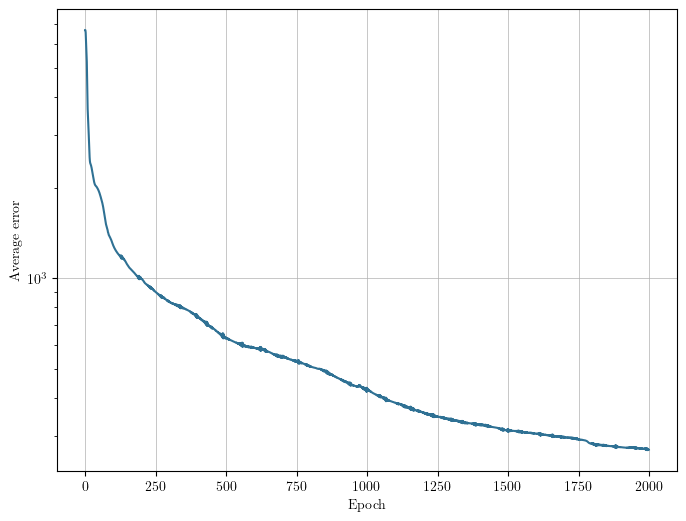

In [151]:
# Plot the training loss
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(len(loss_ts)), np.array(loss_ts))
ax.set_ylabel("Average error")
ax.set_xlabel("Epoch")
ax.set_yscale('log')

Text(0.5, 1.0, 'Prediction')

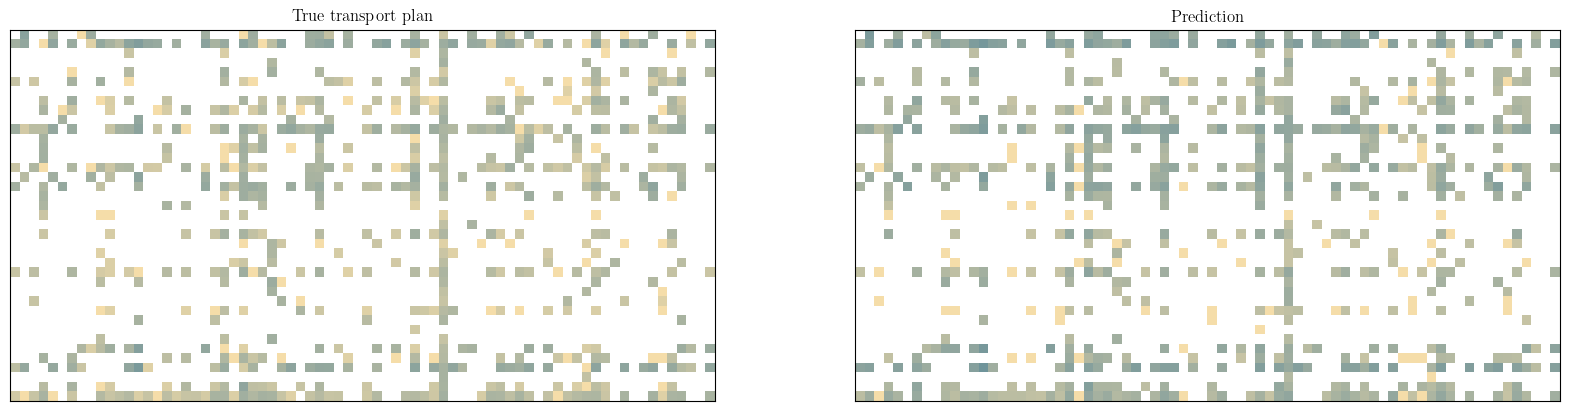

In [18]:
# Plot an example prediction on the training data
idx = np.random.choice(len(training_data), 1)[0]
example_dset = training_data[idx]
_C_pred = NN(example_dset.reshape(M * N, )).reshape(M, N).detach()

# Get the marginals from the predicted cost matrix
m, n = base.Sinkhorn(
    mu[idx],
    nu[idx],
    _C_pred,
    **sinkhorn_kwargs,
)

_, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])

cm = ColorManager(
    cmap={'from_values': {0: colors['c_yellow'], 1: colors['c_darkblue']}, 'continuous': True}, vmin=0, vmax=1
)

fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
axs[0].imshow(np.ma.masked_where(example_dset == 0, example_dset / 1e6), vmin=0, vmax=example_dset.max(), cmap=cm.cmap, norm='log')
axs[0].set_title("True transport plan")
axs[1].imshow(np.ma.masked_where(example_dset == 0, _T_pred / 1e6), vmin=0, vmax=example_dset.max(), cmap=cm.cmap, norm='log')
axs[1].set_title("Prediction")

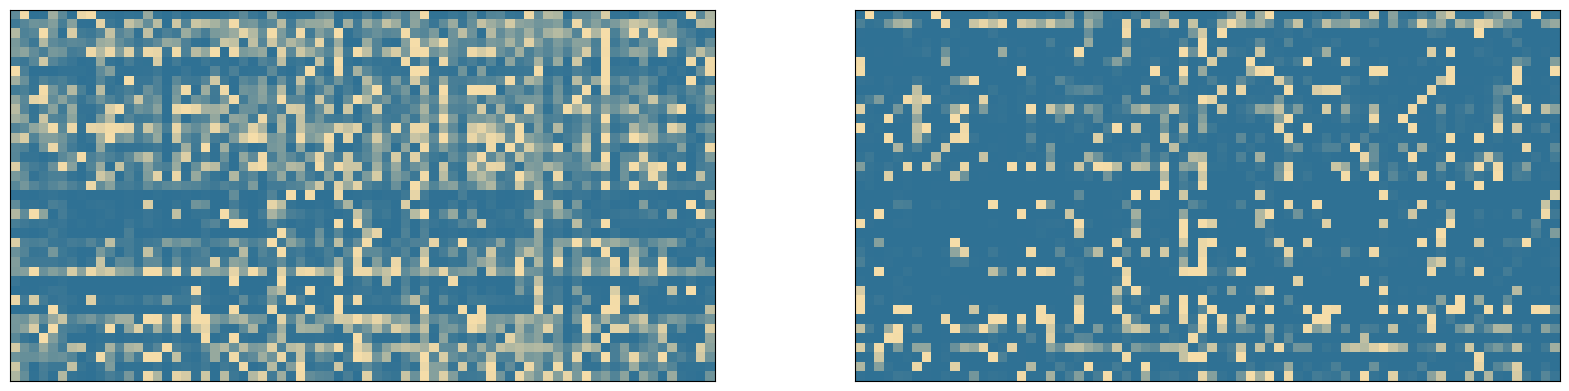

In [17]:
# Plot two example cost matrices
_C_pred_1 = NN(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()
_C_pred_2 = NN(training_data[np.random.choice(len(training_data), 1)[0]].reshape(M * N, )).reshape(M, N).detach()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
axs[0].imshow(_C_pred_1, vmin=0, vmax=1, cmap=cm.cmap)
axs[1].imshow(_C_pred_2, vmin=0, vmax=1, cmap=cm.cmap)

In [152]:
# Now generate predictions on the FAOStat data by randomly picking one of the reporter values for each Year, where available.

# Number of samples for each year
N_samples = 1000

# xr.Dataset containing the data
_empty = np.zeros((N_samples, len(FAO_data.coords['Year'].data), M, N))
samples = xr.Dataset(
    data_vars=dict(
        C=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty)), 
        T=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty)),
        T_pred=(["Sample", "Year", "Source", "Destination"], np.zeros_like(_empty))
    ), 
    coords={"Sample": np.arange(N_samples), 
            "Year": FAO_data.coords["Year"].data, 
            "Source": FAO_data.coords["Source"].data, 
            "Destination": FAO_data.coords["Destination"].data}
)

for j in tqdm(range(N_samples), desc="Sampling"):

    for year in FAO_data.coords['Year'].data:

        # Pick random entries along the 'Reporter' axis and fill NaN values
        _dset = torch.from_numpy(
            np.apply_along_axis(np.random.choice, 0, FAO_data.sel({"Element": "Quantity, t", "Year": year}).data)
        ).float()
        
        _C_pred = NN(_dset.reshape(M * N, )).reshape(M, N).detach()
                
        # Get the marginals from the predicted cost matrix
        m, n = base.Sinkhorn(
            _dset.sum(dim=1, keepdim=True),
            _dset.sum(dim=0, keepdim=True),
            _C_pred,
            **sinkhorn_kwargs,
        )

        _, _, _T_pred = base.marginals_and_transport_plan(m, n, _C_pred, epsilon=sinkhorn_kwargs["epsilon"])
     
        _dset[_dset == 0] = torch.nan
        _C_pred[_dset == 0] = torch.inf

        samples["C"].loc[{"Year": year, "Sample": j}] = _C_pred
        samples["T"].loc[{"Year": year, "Sample": j}] = _dset
        samples["T_pred"].loc[{"Year": year, "Sample": j}] = _T_pred

Sampling: 100%|██████████| 1000/1000 [13:51<00:00,  1.20it/s]


In [138]:
# Compare the prediction on an edge
def comparison_plot(exp, imp, *, figsize = (20, 5)):
    
    # Create a figure
    fig, axs = plt.subplots(ncols=4, figsize=figsize)
    fig.suptitle(f"{FAO_data.name} trade: {exp} to {imp}", fontsize=18, fontweight='bold')
    
    # Track the handles
    handles = dict((idx, []) for idx in range(len(axs)))
    
    for reporter in ['Exporter', 'Importer']:
        
        # True transport flow (quantity)
        _T = FAO_data.sel({"Reporter": reporter, "Element": "Quantity, t", "Source": exp, "Destination": imp}).dropna("Year")

        # True transport flow (value)
        _V = FAO_data.sel({"Reporter": reporter, "Element": "Value, 1000 USD", "Source": exp, "Destination": imp}).dropna("Year")
        
        # Interpolate the quantity and the value
        _x_t, _y_t = _T.coords["Year"], _T.data 
        _s_t = PchipInterpolator(_x_t, _y_t, extrapolate=True)
        _x_v, _y_v = _V.coords["Year"], _V.data 
        _s_v = PchipInterpolator(_x_v, _y_v, extrapolate=True)
        
        # Plot the true quantity flow
        _d = axs[0].scatter(_T.coords["Year"], _T, label=f"Reporter: {reporter}")
        axs[0].set_title(f"{_T.coords['Element'].data.item()}")
        handles[0].append(_d)
        
        # Plot the true value flow
        _d = axs[1].scatter(_V.coords["Year"], _V, label=f"Reporter: {reporter}")
        axs[1].set_title(f"{_V.coords['Element'].data.item()} (interpolated)")
        
        # Plot the interpolated value flow
        _x_v_interp = np.arange(_x_v.min(), _x_v.max()+1, 1)
        _l = axs[1].plot(_x_v_interp, _s_v(_x_v_interp))
        handles[1].append((_d, _l[0]))
        
        # Plot the value per unit
        _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
        _d = axs[2].scatter(_T.coords["Year"], _V / _T)
        axs[2].set_title("Unit cost (USD/kg)")
        handles[2].append((_d, _l[0]))
    
    # Plot the predicted transport flow
    _T_pred = samples["T_pred"].sel({"Source": exp, "Destination": imp})
    _fb = axs[0].fill_between(
        _T_pred.coords["Year"], 
        _T_pred.mean("Sample") - _T_pred.std("Sample"), 
        _T_pred.mean("Sample") + _T_pred.std("Sample"), 
        alpha=0.2, color=colors['c_darkblue']
    )
    _l = axs[0].plot(_T_pred.coords["Year"], _T_pred.mean("Sample"), color=colors['c_darkblue'], linestyle='dotted')
    handles[0].append((_fb, _l[0]))
    
    # Plot the predicted cost
    _C_pred = (samples["C"]).sel({"Source": exp, "Destination": imp})
    _fb = axs[3].fill_between(_C_pred.coords["Year"], 
                        _C_pred.mean("Sample")-_C_pred.std("Sample"), 
                        _C_pred.mean("Sample")+_C_pred.std("Sample"), alpha=0.2, color=colors['c_darkblue'])
    _l = axs[3].plot(_C_pred.coords["Year"], _C_pred.mean("Sample"), label="Predicted C", color=colors['c_darkblue'])
    axs[3].set_title("Predicted cost (unitless)")
    handles[3].append((_fb, _l[0]))
    
    # Add legends
    axs[0].legend(handles=handles[0], labels=['Exporter', 'Importer', 'Prediction'])
    axs[1].legend(handles=handles[1], labels=['Exporter', 'Importer'])
    axs[2].legend(handles=handles[2], labels=['Exporter', 'Importer'])
    axs[3].legend(handles=handles[3], labels=['Cost'])
    
    return fig, axs

/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))


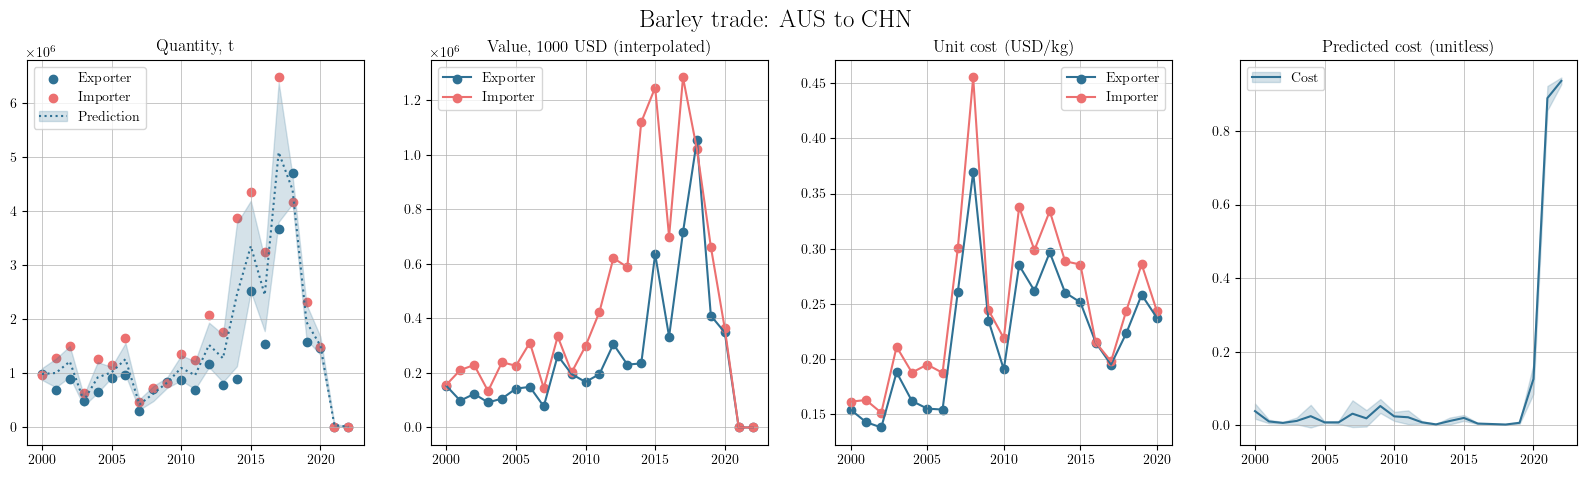

In [155]:
ex, im = "AUS", "CHN"
fig, axs = comparison_plot(ex, im, figsize=(20, 5))
fig.savefig(f"/Users/thomasgaskin/FAOSTAT_data/Barley_{ex}_{im}.png", dpi=300, bbox_inches='tight')

/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))


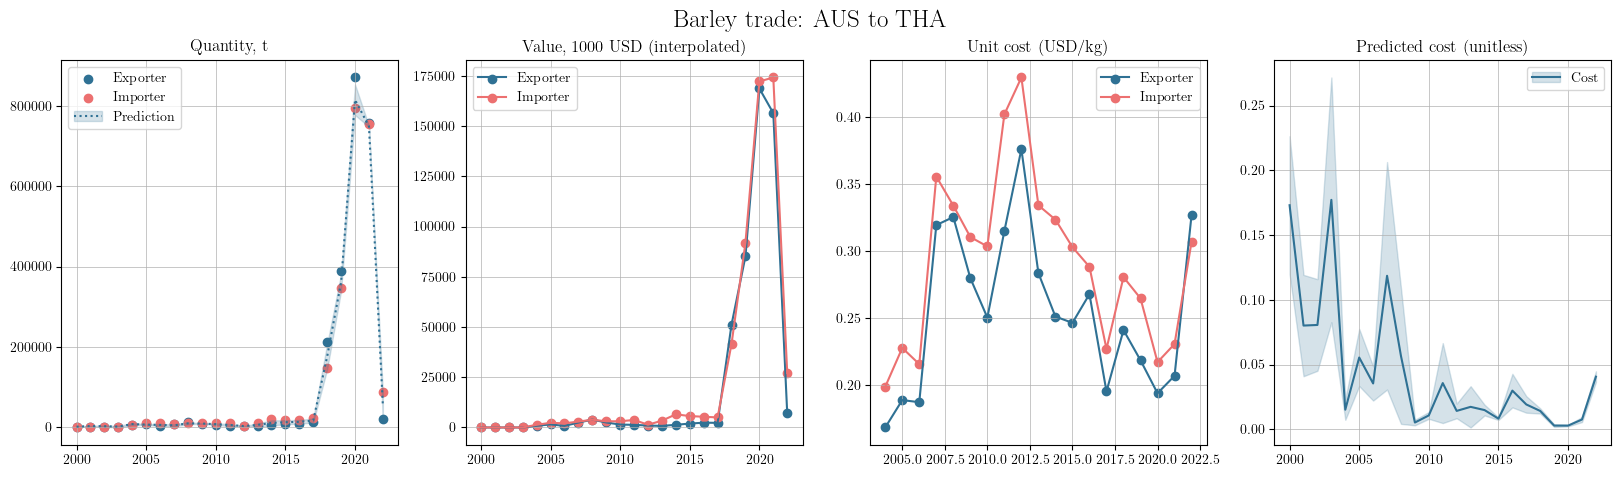

In [158]:
ex, im = "AUS", "THA"
fig, axs = comparison_plot(ex, im, figsize=(20, 5))
fig.savefig(f"/Users/thomasgaskin/FAOSTAT_data/Barley_{ex}_{im}.png", dpi=300, bbox_inches='tight')

/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))
/var/folders/q7/980j630551z68p8jmr50y68r0000gn/T/ipykernel_26205/1560246387.py:40: RuntimeWarning: invalid value encountered in divide
  _l = axs[2].plot(_x_v_interp, _s_v(_x_v_interp) / _s_t(_x_v_interp))


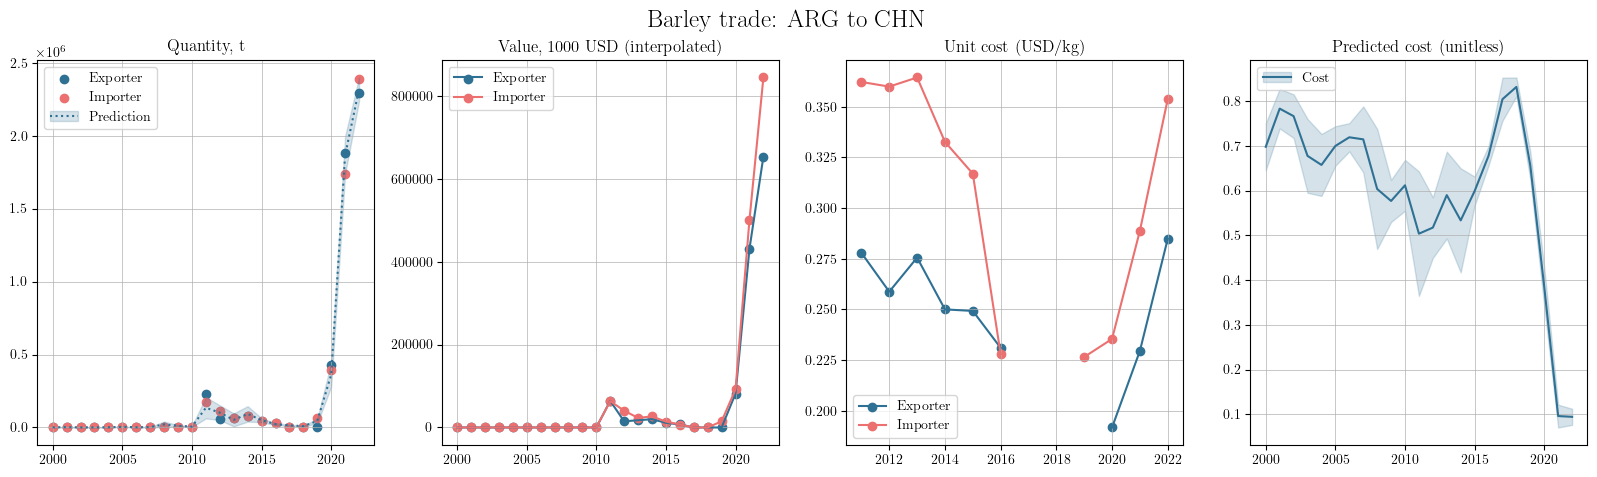

In [171]:
ex, im = "ARG", "CHN"
fig, axs = comparison_plot(ex, im, figsize=(20, 5))
fig.savefig(f"/Users/thomasgaskin/FAOSTAT_data/Barley_{ex}_{im}.png", dpi=300, bbox_inches='tight')

In [0]:
fig, axs = plt.subplots(ncols=2, figsize=(7.5, 4))

importer = "China, mainland"
exporter = "Brazil"
for _country in ["Paraguay", "United States of America", "Brazil"]:
    
    # Plot the cost trajectory for the importer
    _mean = samples["C"].mean("Sample", skipna=True).sel({"Country A": _country, "Country B": importer}, drop=True)
    _std = samples["C"].std("Sample", skipna=True).sel({"Country A": _country, "Country B": importer}, drop=True) 
    
    axs[0].fill_between(_mean.coords['Year'].data, _mean - _std, _mean + _std, alpha=0.4)
    axs[0].plot(_mean.coords['Year'], _mean, label=_country)
axs[0].set_xlim(2000, 2022)
axs[0].legend(title="", ncol=3, loc="upper right", bbox_to_anchor=(0, 1, 1, 0.1), handlelength=0.75, labelspacing=0.3, columnspacing=0.8)

for _country in ["China, mainland", "Germany", "France"]:
    
    # Plot the cost trajectory for the exporter
    _mean = samples["C"].mean("Sample", skipna=True).sel({"Country B": _country, "Country A": exporter}, drop=True) 
    _std = samples["C"].std("Sample", skipna=True).sel({"Country B": _country, "Country A": exporter}) 

    axs[1].fill_between(_mean.coords['Year'].data, _mean - _std, _mean + _std, alpha=0.4)
    axs[1].plot(_mean.coords['Year'], _mean, label=_country)

axs[1].set_xlim(2000, 2022)
axs[1].legend(title="", ncol=3, loc="upper right", bbox_to_anchor=(0, 1, 1, 0.1), handlelength=0.75, labelspacing=0.3, columnspacing=0.8)
# plt.savefig("/Users/thomasgaskin/NN_cost_comparison.pdf", bbox_inches='tight', dpi=600)

In [0]:
# Calculate the predicted RPI for the UK
UK_import_mean_cost = (samples["C"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True) * samples["T"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)).sum("Country A", skipna=True) / samples["T"].mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True).sum("Country A", skipna=True)

UK_import_mean_cost /= UK_import_mean_cost.sel({"Year": 2000}) # Normalise to 2010 levels

# UK inflation rate, 2010-2022
# UK_inflation_rate = np.array([0.0249, 0.0386, 0.0257, 0.0229, 0.0145, 0.0037, 0.0101, 0.0256, 0.0229, 0.0174, 0.0099, 0.0252, 0.0792])

# Load the RPI
import pandas as pd
RPI_data = pd.read_csv('../../data/IOT/ONS_RPI/Avocados_Pears_Feb_24.csv', index_col=0).astype(float).to_xarray().to_array().squeeze(drop=True).sel({"Year": slice(2000, 2022)})


fig, ax = plt.subplots(figsize=(3.75, 2.5))
(UK_import_mean_cost).plot(ax=ax, label='Per-unit import cost')

# Plot the RPI
(RPI_data / RPI_data.isel({"Year": 0})).plot(ax=ax, label='RPI')

# Adjust the RPI for inflation
# RPI_data *= np.array([np.prod(1-UK_inflation_rate[:i]) for i in range(len(UK_inflation_rate+1))])
(RPI_data / RPI_data.isel({"Year": 0})).plot(ax=ax, label='RPI (inflation-adjusted)')
ax.legend()
# plt.savefig("/Users/thomasgaskin/NN_RPI_comparison.pdf", bbox_inches='tight', dpi=600)

In [0]:
# Plot a pie-chart of the import volume and cost
from pie_chart import pie
_data = samples.mean("Sample", skipna=True).sel({"Country B": "China, mainland", "Year": 2022}, drop=True)
_data = _data.where(_data["T"] > 0, drop=True)
plt = pie(
    _data.sortby("C") / _data["C"].mean(),
    x="T", 
    y="C", 
    hue="C",
    cmap=cm.cmap,
    title="China",
    start_angle=110,
    end_angle=470,
    inner_padding_factor=10,
    subplot_kwargs=dict(figsize=(7, 7))
)
# plt.savefig("/Users/thomasgaskin/NN_UK_pie_chart.pdf", bbox_inches='tight', dpi=600)

In [0]:
_data = samples.mean("Sample", skipna=True).sel({"Country A": "United States of America", "Year": 2022}, drop=True)
_data = _data.where(_data["T"] > 0, drop=True)
plt = pie(
    _data.sortby("C") / _data["C"].mean(),
    x="T", 
    y="C", 
    hue="C",
    cmap=cm.cmap,
    title="USA",
    outer_padding=1.1,
    start_angle=50,
    inner_padding_factor=5,
    subplot_kwargs=dict(figsize=(7, 7))
)
# plt.savefig("/Users/thomasgaskin/NN_Mexico_pie_chart.pdf", bbox_inches='tight', dpi=600)

In [0]:
# Plot the discrepancy on the trade matrix
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(7.5, 2.5), sharey=True, sharex=True)

cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors["c_darkgreen"], 1: colors['c_red']}, 'continuous': True}, norm="LogNorm"
)

ds1 = xr.Dataset(
    dict(Discrepancy = abs(samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"] - FAO_data.sel({"Year": slice(2000, None), "Country B": "UK"}, drop=True).mean("Reporter")) / FAO_data.sel({"Year": slice(2000, None), "Country B": "UK"}, drop=True).mean("Reporter"),
         T = samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"] / samples.mean("Sample", skipna=True).sel({"Country B": "UK"}, drop=True)["T"].sum("Year")
         ))

ds1.fillna(0).plot.scatter(x="Year", y="Discrepancy", markersize="T", hue="T", ax=axs[0], lw=0, alpha=0.5, add_legend=False, cmap=cm.cmap, add_colorbar=False)
ds1["Discrepancy"].mean("Country A", skipna=True).plot.line(ax=axs[0], color=colors["c_red"], label="Mean")
ds1["Discrepancy"].median("Country A", skipna=True).plot.line(ax=axs[0], color=colors["c_darkblue"], label="Median")
axs[0].set_yscale('log')
axs[0].legend(ncol=2)

ds2 = xr.Dataset(
    dict(Discrepancy = abs(samples.mean("Sample", skipna=True).sel({"Country A": "Costa Rica"}, drop=True)["T"] - FAO_data.sel({"Year": slice(2000, None), "Country A": "Costa Rica"}, drop=True).mean("Reporter")) / FAO_data.sel({"Year": slice(2000, None), "Country A": "Costa Rica"}, drop=True).mean("Reporter"),
         T = samples.mean("Sample", skipna=True).sel({"Country A": "Costa Rica"}, drop=True)["T"] / samples.mean("Sample", skipna=True).sel({"Country A": "Mexico"}, drop=True)["T"].sum("Year")
         ))

ds2.fillna(0).plot.scatter(x="Year", y="Discrepancy", markersize="T", hue="T", ax=axs[1], lw=0, alpha=0.5, add_legend=False, cmap=cm.cmap)
ds2["Discrepancy"].mean("Country B", skipna=True).plot.line(ax=axs[1], color=colors["c_red"], label="Mean")
ds2["Discrepancy"].median("Country B", skipna=True).plot.line(ax=axs[1], color=colors["c_darkblue"], label="Median")
axs[1].set_yscale('log')
axs[1].set_ylabel('')
# plt.savefig("/Users/thomasgaskin/NN_discrepancies.pdf", bbox_inches='tight', dpi=600)

In [0]:
# Import the value
FAO_data_values = xr.open_dataarray("/Users/thomasgaskin/FAOSTAT_data/Soya beans/All_Data_Soya beans_Value_2000-2022_pooled_0.99.nc")

In [0]:
sample_stats = xr.concat([xr.Dataset(dict(mean=(samples["C"]).mean("Sample", skipna=True), std=(samples["C"]).std("Sample", skipna=True))), xr.Dataset(dict(mean=(FAO_data_values / FAO_data).mean("Reporter"), std=(FAO_data_values / FAO_data).std("Reporter")))], dim=pd.Index(['predicted', 'true'], name='type'))

sample_stats /= sample_stats["mean"].isel({"Year": 0})

In [0]:
# Plot a comparison with the
from dantro.plot.funcs.generic import errorbars
from dantro.plot import PlotHelper

In [0]:
hlpr = PlotHelper(
    out_path="",
    helper_defaults={},
    raise_on_error=True,
)
hlpr.setup_figure()

errorbars(data={"data": sample_stats.sel({"Country A": ["Brazil", "Paraguay", "United States of America"], "Country B": ["China, mainland", "Spain", "Mexico", "Netherlands (Kingdom of the)"]})}, hlpr=hlpr, x="Year", y='mean', yerr='std', row='Country A', col='Country B', hue="type", use_bands=True, sharey=False, add_guide=True)

In [0]:
FAO_data.coords